# Marketing Analytics: Airline Perceptual Map Analysis Using Tweets

This is a marketing analytics project that helps answer the following questions: how do US travelers perceive different domestic airlines? Do certain airlines have better brand perception than others? In this project, a dataset with tweets about domestic US airlines from February 2015 is used to create a perceptual map of the US Airline Market, which can be used to understand how US domestic travelers perceived different airlines in 2015.

# Standard Imports

In [7]:
import numpy as np
import pandas as pd
import re

In [8]:
import time
import math
import re
from textblob import TextBlob
import pandas as pd

import nltk as nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

import string

import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')

import gensim
from gensim import corpora, models
from gensim.models.ldamulticore import LdaMulticore
import pyLDAvis.gensim

In [9]:
tweets = pd.read_csv('/Users/Monu/Desktop/MSc Analytics/Classes/Quarter 3/Marketing Analytics/Marketing Analytics Final Project/Tweets.csv')

In [10]:
tweets.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [11]:
tweets.airline.value_counts()

United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline, dtype: int64

In [12]:
tweets['text_clean'] = tweets['text'].map(lambda x: re.sub('[^a-zA-Z0-9  . , : - _]', '', str(x)))

In [13]:
tweets.text_clean = tweets.text_clean.str.lower()

In [14]:
tweets[['text','text_clean']][-15:]

,text,text_clean
14625,@AmericanAir Flight 236 was great. Fantastic c...,americanair flight 236 was great. fantastic ca...
14626,@AmericanAir Flight 953 NYC-Buenos Aires has b...,americanair flight 953 nycbuenos aires has bee...
14627,"@AmericanAir Flight Cancelled Flightled, can't...","americanair flight cancelled flightled, cant g..."
14628,Thank you. “@AmericanAir: @jlhalldc Customer R...,thank you. americanair: jlhalldc customer rela...
14629,@AmericanAir How do I change my flight if the ...,americanair how do i change my flight if the p...
14630,@AmericanAir Thanks! He is.,americanair thanks he is.
14631,@AmericanAir thx for nothing on getting us out...,americanair thx for nothing on getting us out ...
14632,"“@AmericanAir: @TilleyMonsta George, that does...","americanair: tilleymonsta george, that doesnt ..."
14633,@AmericanAir my flight was Cancelled Flightled...,"americanair my flight was cancelled flightled,..."
14634,@AmericanAir right on cue with the delays👌,americanair right on cue with the delays


# VADER Sentiment Analysis

In [15]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

In [16]:
tweets['vader_sentiment'] = tweets.text_clean.apply(lambda x:analyser.polarity_scores(x))

In [17]:
def sentiment_parser(x):
    if x['compound'] <= -0.05:
        return 'negative'
    elif x['compound'] >= 0.05:
        return 'positive'
    else:
        return 'neutral'

In [18]:
tweets['v_sentiment'] = tweets['vader_sentiment'].apply(lambda x:sentiment_parser(x))

In [19]:
pd.crosstab(tweets.airline_sentiment,tweets.v_sentiment)

v_sentiment,negative,neutral,positive
airline_sentiment,,,
negative,3964,1498,3716
neutral,355,1048,1696
positive,86,182,2095


# TF-IDF

In [20]:
# http://stevenloria.com/finding-important-words-in-a-document-using-tf-idf/

def tf(word, blob):
    return blob.words.count(word) / len(blob.words)
# tf(word, blob) computes "term frequency" which is the number of times a word appears in a document blob, 
# normalized by dividing by the total number of words in blob. We use TextBlob for breaking up the text into words 
# and getting the word counts.


def n_containing(word, bloblist):
    return sum(1 for blob in bloblist if word in blob.words)
# n_containing(word, bloblist) returns the number of documents containing word. 
# A generator expression is passed to the sum() function.


def idf(word, bloblist):
    return math.log(len(bloblist) / (1 + n_containing(word, bloblist)))
# idf(word, bloblist) computes "inverse document frequency" which measures how common a word is 
# among all documents in bloblist. The more common a word is, the lower its idf. 
# We take the ratio of the total number of documents to the number of documents containing word, 
# then take the log of that. Add 1 to the divisor to prevent division by zero


def tfidf(word, blob, bloblist):
    return tf(word, blob) * idf(word, bloblist)
# tfidf(word, blob, bloblist) computes the TF-IDF score. It is simply the product of tf and idf.

In [21]:
bloblist = []
del bloblist[:]

for i  in range(0,len(tweets)):
    bloblist.append(TextBlob(tweets['text_clean'].iloc[i]))
    
len(bloblist)

14640

In [22]:
for i, blob in enumerate(bloblist):
# Print top 5 values
    if i == 5:
        break
    print("Top words in tweet {}".format(i + 1))
    scores = {word: tfidf(word, blob, bloblist) for word in blob.words}
    sorted_words = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    for word, score in sorted_words[:5]:
        print("\tWord: {}, TF-IDF: {}".format(word, round(score, 5)))

Top words in tweet 1
	Word: dhepburn, TF-IDF: 2.22459
	Word: said, TF-IDF: 1.10526
	Word: virginamerica, TF-IDF: 0.83635
	Word: what, TF-IDF: 0.77596
Top words in tweet 2
	Word: tacky, TF-IDF: 0.98871
	Word: commercials, TF-IDF: 0.84951
	Word: added, TF-IDF: 0.72744
	Word: plus, TF-IDF: 0.61266
	Word: youve, TF-IDF: 0.61266
Top words in tweet 3
	Word: must, TF-IDF: 0.50067
	Word: mean, TF-IDF: 0.46385
	Word: trip, TF-IDF: 0.35653
	Word: didnt, TF-IDF: 0.3533
	Word: take, TF-IDF: 0.33495
Top words in tweet 4
	Word: blast, TF-IDF: 0.49958
	Word: obnoxious, TF-IDF: 0.49958
	Word: aggressive, TF-IDF: 0.48266
	Word: faces, TF-IDF: 0.48266
	Word: guests, TF-IDF: 0.46953
Top words in tweet 5
	Word: thing, TF-IDF: 0.5343
	Word: big, TF-IDF: 0.53148
	Word: bad, TF-IDF: 0.44154
	Word: really, TF-IDF: 0.39012
	Word: about, TF-IDF: 0.3393


## Topic Modeling 

## LDA (latent dirichlet allocation)
#### LDA is a matrix factorization technique, which assumes documents are produced from a mixture of topics. Those topics then generate words based on their probability distribution.

In [23]:
doc_complete = list(tweets.text_clean)

In [24]:
stop_airline_names = ['jetblue','americanair','united','virginamerica', 'virgin','usairways','southwest','delta','southwestair','flight']

In [25]:
stop = set(stopwords.words('english')).union(stop_airline_names)
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()
def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

doc_clean = [clean(doc).split() for doc in doc_complete]     

In [26]:
final_list = []
for i in doc_clean:
    initial_list = []
    for j in i:
        if j not in stop_airline_names:
            initial_list.append(j)
    final_list.append(initial_list)

In [27]:
doc_clean = final_list

In [28]:
len(doc_clean)

14640

In [29]:
doc_clean[:3]

[['dhepburn', 'said'],
 ['plus', 'youve', 'added', 'commercial', 'experience', 'tacky'],
 ['didnt', 'today', 'must', 'mean', 'need', 'take', 'another', 'trip']]

In [30]:
# Creating the term dictionary of our courpus, where every unique term is assigned an index. 
dictionary = corpora.Dictionary(doc_clean)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]

In [31]:
# Creating the object for LDA model using gensim library
Lda = gensim.models.ldamodel.LdaModel

In [32]:
%time ldamodel = LdaMulticore(doc_term_matrix, num_topics=3, id2word = dictionary, passes=50) #3 topics
print(*ldamodel.print_topics(num_topics=3, num_words=10), sep='\n')

CPU times: user 1min 47s, sys: 13.4 s, total: 2min
Wall time: 2min 10s
(0, '0.022*"thanks" + 0.019*"customer" + 0.017*"service" + 0.012*"thank" + 0.008*"airline" + 0.007*"dont" + 0.007*"seat" + 0.006*"guy" + 0.006*"great" + 0.006*"would"')
(1, '0.017*"help" + 0.016*"get" + 0.015*"cancelled" + 0.014*"cant" + 0.012*"phone" + 0.011*"call" + 0.011*"need" + 0.010*"u" + 0.009*"change" + 0.008*"please"')
(2, '0.021*"hour" + 0.013*"bag" + 0.012*"time" + 0.012*"get" + 0.011*"plane" + 0.010*"cancelled" + 0.009*"2" + 0.008*"still" + 0.008*"delayed" + 0.008*"gate"')


In [33]:
lda_display = pyLDAvis.gensim.prepare(ldamodel, doc_term_matrix, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [34]:
%time ldamodel = LdaMulticore(doc_term_matrix, num_topics=8, id2word = dictionary, passes=50) #3 topics
print(*ldamodel.print_topics(num_topics=8, num_words=15), sep='\n')

CPU times: user 1min 31s, sys: 11 s, total: 1min 42s
Wall time: 1min 57s
(0, '0.057*"cancelled" + 0.028*"flightled" + 0.017*"u" + 0.017*"tomorrow" + 0.012*"get" + 0.012*"flighted" + 0.009*"im" + 0.009*"delay" + 0.007*"hotel" + 0.007*"today" + 0.007*"amp" + 0.007*"help" + 0.007*"dfw" + 0.007*"rebooked" + 0.007*"connection"')
(1, '0.016*"ticket" + 0.013*"u" + 0.013*"one" + 0.010*"would" + 0.008*"change" + 0.007*"mile" + 0.007*"make" + 0.007*"dont" + 0.007*"fleek" + 0.007*"fleet" + 0.006*"credit" + 0.006*"help" + 0.006*"get" + 0.006*"fee" + 0.006*"want"')
(2, '0.030*"call" + 0.028*"get" + 0.027*"hold" + 0.024*"hour" + 0.021*"phone" + 0.019*"help" + 0.016*"cant" + 0.013*"trying" + 0.012*"2" + 0.012*"back" + 0.011*"reservation" + 0.010*"need" + 0.009*"number" + 0.009*"ive" + 0.009*"online"')
(3, '0.021*"plane" + 0.015*"time" + 0.015*"seat" + 0.014*"minute" + 0.014*"hour" + 0.012*"min" + 0.011*"bag" + 0.009*"waiting" + 0.008*"first" + 0.008*"sitting" + 0.007*"gate" + 0.007*"still" + 0.007*"d

In [35]:
lda_display = pyLDAvis.gensim.prepare(ldamodel, doc_term_matrix, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


### Topic 1 - Customer Service

In [36]:
customer_service_tweets = tweets[tweets.text_clean.str.contains('service|customer|hold|call|phone|CS|agent|help|response|email|message|communication')] 

In [37]:
len(customer_service_tweets)

4340

In [38]:
#removing words not related to "customer service"
customer_service_tweets = customer_service_tweets[~ customer_service_tweets.text_clean.str.contains('cancelled')]
customer_service_tweets = customer_service_tweets[~ customer_service_tweets.text_clean.str.contains('delay')]
customer_service_tweets = customer_service_tweets[~ customer_service_tweets.text_clean.str.contains('seat')]
customer_service_tweets = customer_service_tweets[~ customer_service_tweets.text_clean.str.contains('airplane')]
customer_service_tweets = customer_service_tweets[~ customer_service_tweets.text_clean.str.contains('luggage')]
customer_service_tweets = customer_service_tweets[~ customer_service_tweets.text_clean.str.contains('bag')]
customer_service_tweets = customer_service_tweets[~ customer_service_tweets.text_clean.str.contains('http')]

In [39]:
len(customer_service_tweets)

3240

In [40]:
#customer_service_tweets.negativereason.value_counts()

In [41]:
list(customer_service_tweets.text_clean)[:15]

['virginamerica status match program.  i applied and its been three weeks.  called and emailed with no response.',
 'virginamerica awaiting my return phone call, just would prefer to use your online selfservice option :',
 'virginamerica hey, first time flyer next week  excited but im having a hard time getting my flights added to my elevate account. help',
 'virginamerica plz help me win my bid upgrade for my flight 227 laxgtsea  ',
 'virginamerica i have an unused ticket but moved to a new city where you dont fly. how can i fly with you before it expires travelhelp',
 'virginamerica i called a 34 weeks ago about adding 3 flights from 2014 to my elevate...they still havent shown up...help',
 'virginamerica heyyyy guyyyys.. been trying to get through for an hour. can someone call me please :',
 'virginamerica hi, virgin im on hold for 4050 minutes  are there any earlier flights from la to nyc tonight earlier than 11:50pm',
 'virginamerica need to change reservation. have virgin credit 

In [42]:
list(customer_service_tweets.text_clean)[-15:]

['americanair thank you for quick responses.   aa usually has fantastic customer service. thats why i was so shocked when it wasnt there',
 'americanair  beyond frustrated with no call back from auto hold or whatever you call it. entered my number at 11:30 cst, still no call 2:26',
 'americanair hey aa  can you help with an itinerary for a plat custy  stuck in pvr and phones arent working',
 'americanair weve been on hold for hours.',
 'americanair can you guys help me please',
 'americanair trying to book a flight on hold cant get through to a representative on the phone advice',
 'americanair i need someone to help me out',
 'americanair i used the call back feature with an operator regarding my flight, got a call 2 hours late flightr and got hung up on. pleasehelp',
 'americanair i need to be at work tomorrow at 8am, therefore that doesnt help.  direct message faster than calling 800 number backwards',
 'americanair i wait 2 hrs for cs to call me back re why  flt is cxldprotection a

In [43]:
percent_calc = lambda y:y.sum()/y.count()

In [44]:
cust_service_counts = customer_service_tweets.groupby(['airline','airline_sentiment']).agg({'tweet_id':['count']})

In [45]:
cust_service_counts

tweet_id
                                    count
airline        airline_sentiment         
American       negative               642
               neutral                 73
               positive                64
Delta          negative               168
               neutral                 51
               positive                72
Southwest      negative               298
               neutral                 73
               positive                91
US Airways     negative               726
               neutral                 73
               positive                70
United         negative               548
               neutral                110
               positive               109
Virgin America negative                42
               neutral                 16
               positive                14

In [46]:
cust_service_counts.groupby(level=0).apply(lambda x:x / float(x.sum()))

tweet_id
                                     count
airline        airline_sentiment          
American       negative           0.824134
               neutral            0.093710
               positive           0.082157
Delta          negative           0.577320
               neutral            0.175258
               positive           0.247423
Southwest      negative           0.645022
               neutral            0.158009
               positive           0.196970
US Airways     negative           0.835443
               neutral            0.084005
               positive           0.080552
United         negative           0.714472
               neutral            0.143416
               positive           0.142112
Virgin America negative           0.583333
               neutral            0.222222
               positive           0.194444

In [47]:
cust_percent = cust_service_counts.groupby(level=0).apply(lambda x:x / float(x.sum()))

In [48]:
names = cust_percent.index.get_level_values(0)
values = np.square(cust_percent.values)

In [49]:
print('Final Scores:')
print(names[0])
print(1-np.sum(values[0:3]))
print(names[3])
print(1-np.sum(values[3:6]))
print(names[6])
print(1-np.sum(values[6:9]))
print(names[9])
print(1-np.sum(values[9:12]))
print(names[12])
print(1-np.sum(values[12:15]))

Final Scores:
American
0.30527271558777347
Delta
0.5747688383462644
Southwest
0.5201832799235396
US Airways
0.288489474429956
United
0.4487658276799328


In [50]:
cust_service_scores = [1-np.sum(values[0:3]),1-np.sum(values[3:6]),1-np.sum(values[6:9]),1-np.sum(values[9:12]),1-np.sum(values[12:15])]

### Topic 2 - Cancellations + Delays

In [51]:
cancellations_tweets = tweets[tweets.text_clean.str.contains('cancellation|cancel|next|late|delay|wait|hour|2|due|hr|weather|degree|issue|rebook|fix|connection|stuck|day|yesterday|reschedule|tommorow|today|miss|early|arrive|jfk|sfo|ewr|lax|ord|day|problem|minute|min|time|lga')] 

In [52]:
len(cancellations_tweets)

8110

In [53]:
#removing words not related to "cancellations or delays"
cancellations_tweets = cancellations_tweets[~ cancellations_tweets.text_clean.str.contains('http|service|customer|hold|call|phone|CS|agent|help|response|email|message|communication|luggage|bag|food')]

In [54]:
len(cancellations_tweets)

4452

In [55]:
list(cancellations_tweets.text_clean)[100:115]

['virginamerica spending my birthday night with you, daldca. get me home',
 'virginamerica first time flying virgin, went to sanfrancisco .thanks for the smooth ride. easily my new fav airline',
 'virginamerica seriously, though. will there not be direct flights from sfofll in may',
 'virginamerica its fine. already done with my purchase. but you should try it. just go most of the way through then go back 3',
 'virginamerica not really the experience i was hoping 4, i ws forced 2 check in a small carry on, w nothing but empty cabin space on board',
 'virginamerica ok first time flying with you tonight :',
 'virginamerica digging the swanky pink mood lighting during the flight from nyc to sfo.  just needs a cabaret singer.  think about it',
 'virginamerica on vx399 from jfk to la  dirty plane  not up to your standards.',
 'virginamerica on flight vx399 headed to la from jfk  dirtiest va plane i have ever been on. sad for a great airline.',
 'virginamerica delayed to10.30',
 'virginameri

In [56]:
list(cancellations_tweets.text_clean)[-15:]

['americanair what are my chances of making a connection to el paso aa504 with dfw from sat aa200 delayed 30 minutes',
 'americanair shannonbloom wheres my dm wheres my voucher whos paying my 70 cab and my 50 car back to jfk tomorrow',
 'americanair do you guys have another flight for today that you can book me on from laguardia to louisville ky',
 'americanair my flight out of tyr tomorrow was cancelled flighted due to weather. how long until a rebook',
 'americanair has aa flight 296 from san antonio to dallas been cancelled flighted',
 'americanair cancelled flights flights arbitrarily on same itinerary.  weekend ruined for no good reason no crew  missed monday am mtg.',
 'americanair my flight was cancelled flightled from laguardia to louisville ky and i am  stuck at the airport. do you guys compensate for this',
 'americanair i understand the weather issue but you cant expect passengers to wait 24 hours inside airports for whatever reason. outrageous',
 'americanair dming you now 

In [57]:
cancellation_counts = cancellations_tweets.groupby(['airline','airline_sentiment']).agg({'tweet_id':['count']})

In [58]:
cancellation_counts

tweet_id
                                    count
airline        airline_sentiment         
American       negative               582
               neutral                126
               positive                77
Delta          negative               388
               neutral                146
               positive               129
Southwest      negative               365
               neutral                195
               positive               135
US Airways     negative               744
               neutral                 95
               positive                53
United         negative               968
               neutral                205
               positive               101
Virgin America negative                63
               neutral                 46
               positive                34

In [59]:
cancel_percent = cancellation_counts.groupby(level=0).apply(lambda x:x / float(x.sum()))

In [60]:
cancel_percent

tweet_id
                                     count
airline        airline_sentiment          
American       negative           0.741401
               neutral            0.160510
               positive           0.098089
Delta          negative           0.585219
               neutral            0.220211
               positive           0.194570
Southwest      negative           0.525180
               neutral            0.280576
               positive           0.194245
US Airways     negative           0.834081
               neutral            0.106502
               positive           0.059417
United         negative           0.759812
               neutral            0.160911
               positive           0.079278
Virgin America negative           0.440559
               neutral            0.321678
               positive           0.237762

In [61]:
names = cancel_percent.index.get_level_values(0)
values = np.square(cancel_percent.values)

In [62]:
print('Final Scores:')
print(names[0])
print(1-np.sum(values[0:3]))
print(names[3])
print(1-np.sum(values[3:6]))
print(names[6])
print(1-np.sum(values[6:9]))
print(names[9])
print(1-np.sum(values[9:12]))
print(names[12])
print(1-np.sum(values[12:15]))

Final Scores:
American
0.41493934845227
Delta
0.5711685764919727
Southwest
0.6077325190207546
US Airways
0.28943624444489136
United
0.39050913204310833


In [63]:
cancel_percent_scores = [1-np.sum(values[0:3]),1-np.sum(values[3:6]),1-np.sum(values[6:9]),1-np.sum(values[9:12]),1-np.sum(values[12:15])]

### Topic 3 - Overall Service (In Flight Experience + Luggage Issues)

In [64]:
overall_service = tweets[tweets.text_clean.str.contains('lost|luggage|bag|baggage|wifi|leg|seat|device|movie|entertainment|recline|food|aircraft|plane|inflight|tv|cabin|broken|meal|space|sitting|coach|economy')] 

In [65]:
len(overall_service)

2948

In [66]:
overall_service = overall_service[~ overall_service.text_clean.str.contains('customer|call|delay|cancel|time|hold|call|phone|CS|agent|help|response|email|message|communication|weather')]

In [67]:
len(overall_service)

1915

In [68]:
overall_service.negativereason.value_counts()

Lost Luggage                   403
Bad Flight                     297
Late Flight                    235
Can't Tell                     145
Customer Service Issue         136
Flight Attendant Complaints     88
Flight Booking Problems         47
longlines                       45
Damaged Luggage                 36
Cancelled Flight                28
Name: negativereason, dtype: int64

In [69]:
list(overall_service.text_clean)[:15]

['virginamerica its really aggressive to blast obnoxious entertainment in your guests faces amp they have little recourse',
 'virginamerica seriously would pay 30 a flight for seats that didnt have this playing.its really the only bad thing about flying va',
 'virginamerica you guys messed up my seating.. i reserved seating with my friends and you guys gave my seat away ...  i want free internet',
 'virginamerica what happened 2 ur vegan food options at least say on ur site so i know i wont be able 2 eat anything for next 6 hrs fail',
 'virginamerica lax to ewr  middle seat on a red eye. such a noob maneuver. sendambien andchexmix',
 'virginamerica everything was fine until you lost my bag',
 'virginamerica hi i just booked a flight but need to add baggage, how can i do this',
 'virginamerica not worried, its been a great ride in a new plane with great crew. all airlines should be like this.',
 'virginamerica ive applied more then once to be a member of the inflight crew team...im 100 

In [70]:
list(overall_service.text_clean)[-15:]

['americanair after all, the plane didnt land in identical or worse conditions at grk according to metars.',
 'americanair i was flying from ft lauderdale fl to seattle wa on the 02282015 until the 03032015 and they dont want to honor my flight.',
 'americanair since we are leaving tomorrow to miami can you do one thing right and deliver the bags to the airport',
 'americanair i wasnt important this morning when you would not seat my wife and i together or allow me to choose seats at flight booking problems',
 'americanair because of you, i am doing the one thing i tried to avoid. thank you for sending me to baggage claim.',
 'americanair thanks for forcing me to check in my carry  on luggage. that is exactly why i spent extra money on travel size toiletries',
 'americanair i really hope it departs. they said is because the catering service wasnt available but we can see it next to plane doing nthin',
 'americanair when i left orlando, i was 2nd in line for standby. i land and im 4th. 

In [71]:
overall_service_counts = overall_service.groupby(['airline','airline_sentiment']).agg({'tweet_id':['count']})

In [72]:
overall_service_counts

tweet_id
                                    count
airline        airline_sentiment         
American       negative               247
               neutral                 40
               positive                27
Delta          negative               149
               neutral                 64
               positive                49
Southwest      negative               178
               neutral                 37
               positive                29
US Airways     negative               319
               neutral                 34
               positive                17
United         negative               526
               neutral                 82
               positive                50
Virgin America negative                41
               neutral                 12
               positive                14

In [73]:
overall_percent = overall_service_counts.groupby(level=0).apply(lambda x:x / float(x.sum()))

In [74]:
overall_percent

tweet_id
                                     count
airline        airline_sentiment          
American       negative           0.786624
               neutral            0.127389
               positive           0.085987
Delta          negative           0.568702
               neutral            0.244275
               positive           0.187023
Southwest      negative           0.729508
               neutral            0.151639
               positive           0.118852
US Airways     negative           0.862162
               neutral            0.091892
               positive           0.045946
United         negative           0.799392
               neutral            0.124620
               positive           0.075988
Virgin America negative           0.611940
               neutral            0.179104
               positive           0.208955

In [75]:
names = overall_percent.index.get_level_values(0)
values = np.square(overall_percent.values)

In [76]:
print('Final Scores:')
print(names[0])
print(1-np.sum(values[0:3]))
print(names[3])
print(1-np.sum(values[3:6]))
print(names[6])
print(1-np.sum(values[6:9]))
print(names[9])
print(1-np.sum(values[9:12]))
print(names[12])
print(1-np.sum(values[12:15]))

Final Scores:
American
0.35760071402490956
Delta
0.5819299574616864
Southwest
0.430697393173878
US Airways
0.2461212563915267
United
0.3396679631562901


In [77]:
overall_service_scores = [1-np.sum(values[0:3]),1-np.sum(values[3:6]),1-np.sum(values[6:9]),1-np.sum(values[9:12]),1-np.sum(values[12:15])]

## Final Perceptual Map

In [78]:
airlines = ['American','Delta','Southwest','US Airways','United']

In [79]:
cust_service_scores = pd.DataFrame(cust_service_scores)
cancel_percent_scores = pd.DataFrame(cancel_percent_scores)
overall_service_scores = pd.DataFrame(overall_service_scores)

In [80]:
final_scores = pd.concat([cust_service_scores,cancel_percent_scores,overall_service_scores],axis=1)
final_scores

,0,0,0
0,0.305273,0.414939,0.357601
1,0.574769,0.571169,0.581930
2,0.520183,0.607733,0.430697
3,0.288489,0.289436,0.246121
4,0.448766,0.390509,0.339668


In [81]:
final_scores.columns = ['Customer Service','Cancellations + Delays','Overall Service']

In [82]:
final_scores.index = airlines

In [83]:
final_scores = round(final_scores*10,2)

In [84]:
final_scores

,Customer Service,Cancellations + Delays,Overall Service
American,3.05,4.15,3.58
Delta,5.75,5.71,5.82
Southwest,5.20,6.08,4.31
US Airways,2.88,2.89,2.46
United,4.49,3.91,3.40


In [85]:
list(final_scores.index)

['American', 'Delta', 'Southwest', 'US Airways', 'United']

## Perceptual Map

In [86]:
from sklearn.manifold import MDS

In [87]:
embedding = MDS(n_components=2,random_state=2019)
scores_transformed = embedding.fit_transform(final_scores)
scores_transformed.shape

(5, 2)

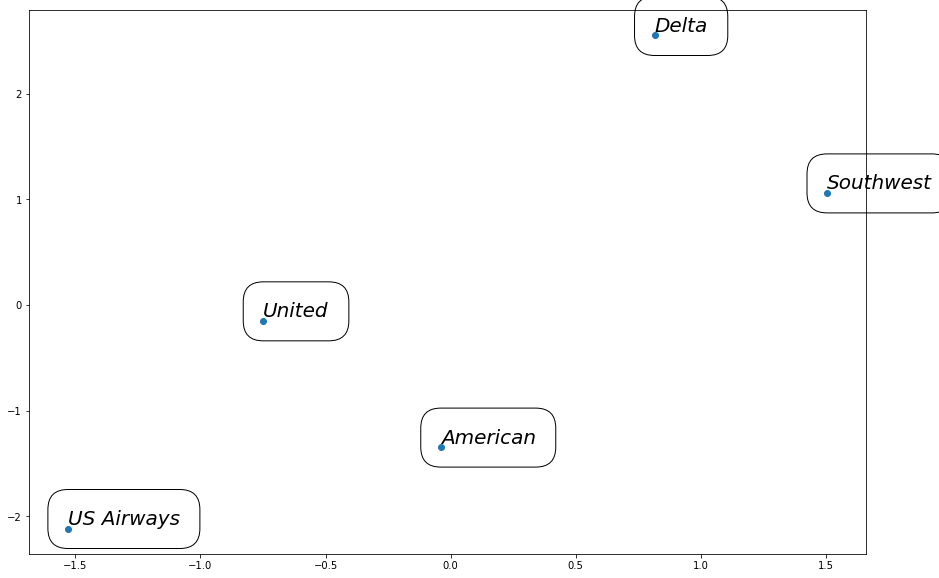

In [89]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(15, 10))
ax.scatter(scores_transformed[:,0],scores_transformed[:,1])

for i, txt in enumerate(list(final_scores.index)):
    ax.annotate(txt, (scores_transformed[i,0], scores_transformed[i,1]),fontsize=20,
                 style='italic',horizontalalignment='left',verticalalignment='bottom',
                bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=1'),
               annotation_clip=False)